https://www.kaggle.com/code/paperboiii/one-class-classification-for-images/input

# One Class Classification for Images
<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/9/9f/King_of_Europe_Round_3_Lydden_Hill_2014_%2814356011899%29.jpg" alt="Car" title="Car" />

## Intro

Binary classification is arguably the most widely documented domain of supervised machine learning, at least within its application toward classifying non-Image data. In a ham vs spam email detector, the data for each class is bound by the limitations of the medium; each instance will most definitely be a variant of an email. However, an interesting problem arises when attempting to apply a ham vs spam concept with image classification.

## The Problem

Consider the issue that arises when building a model whose purpose it is to determine whether a car exists in its field of view. You may have several thousand images of cars you would like to train the model to recognize, but what about instances of “Not Car” images? It doesn’t take long for one to realize that unlike the data in the ham vs spam email problem, the amount of instances that qualify as “Not Car” are near infinite: infinity \ car if you want to be cheeky about it. 

## A Solution

While there are several pretrained models for classifying cars, projects in an industry are not always so straightforward. When faced with one such project, I found the documentation around this “One Class Classification” idea to be pretty paltry. There were several recommendations of building a model with autoencoders, but as a infrequent practitioner of Keras and naive in the space of image classification overall, I found such methods to be a little hard to “pick up and go” within the span of a few hours (maybe one of you readers could contribute a kernel taking this approach for the rest of us).

I did find one promising article written by Aniket Bhatnagar on Hackernoon though. Instead of building a custom model with auto-encoders, Aniket outlined the process of extracting features with the popular ResNet50 model, scaling and reducing the dimensionality of such features, then using a selection of scikit-learn algorithms for classification; all of this while training only on positive class images (the GMM model however uses a combination of positive/not positive images in its validation set). 

I implemented Aniket’s procedure to a project with industry data and was pleased with its results, even before optimization. However, while the article was very informative, it did not include the complete code to create a project from scratch, which is the inspiration behind this notebook. Aniket’s article is also listed below; I definitely recommend reading it alongside this notebook.

https://hackernoon.com/one-class-classification-for-images-with-deep-features-be890c43455d 


## Preparing Train, Test, and Validation Data

The training data is comprised of ONLY car images from the Natural Images and Stanford Cars Dataset. The validation and test data contain car images from the same datasets as well as other image types (listed below) from the Natural Images dataset.

In [13]:
# import libraries
from IPython.display import Image, display
import numpy as np
import os
from os.path import join
from PIL import ImageFile
import pandas as pd
from matplotlib import cm
import seaborn as sns
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.isotonic import IsotonicRegression
import re

ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.style.use('fivethirtyeight')
%matplotlib inline

In [14]:
# import car images from natural images
train_img_dir_n = "../OneClass/Ticks/train"
train_img_paths_n = [join(train_img_dir_n,filename) for filename in os.listdir(train_img_dir_n)]

In [15]:
# import car images from stanford cars
train_img_dir_s = "../OneClass/Other/Ticks"
all_train_img_paths_s = [join(train_img_dir_s,filename) for filename in os.listdir(train_img_dir_s)]

# split cars data into train, test, and val
train_img_paths, test_img_paths_car = train_test_split(all_train_img_paths_s+train_img_paths_n, test_size=0.25, random_state=42)
train_img_paths, val_img_paths_car = train_test_split(train_img_paths, test_size=0.25, random_state=42)

In [16]:
#  import ~car images
natural_images_path = "../OneClass/Other/"
test_img_paths_no_car = []
for d in [d for d in os.listdir("../OneClass/Other") if d!= "car"]:
    test_img_dir_na = natural_images_path+d
    test_img_paths_no_car.append([join(test_img_dir_na,filename) for filename in os.listdir(test_img_dir_na)])
    
test_img_paths_no_car_flat = [item for sublist in test_img_paths_no_car for item in sublist]
test_img_paths_no_car, val_img_paths_no_car = train_test_split(test_img_paths_no_car_flat, test_size = 0.25, random_state = 42)

In [17]:
def natural_img_dir(image_path):
    path_regex = r"Other\/(\w*)"
    if 'Other' in image_path:
        return re.findall(path_regex,image_path,re.MULTILINE)[0].strip()
    else:
        return 'car'

In [18]:
# create test dataframe
all_test_paths = test_img_paths_car+test_img_paths_no_car
test_path_df = pd.DataFrame({
    'path': all_test_paths,
    'is_car': [1 if path in test_img_paths_car else 0 for path in all_test_paths]
})
test_path_df = shuffle(test_path_df,random_state = 0).reset_index(drop = True)
test_path_df['image_type'] = test_path_df['path'].apply(lambda x: natural_img_dir(x))
all_test_paths = test_path_df['path'].tolist()

In [19]:
print('Distribution of Image Types in Test Set')
print(test_path_df['image_type'].value_counts())

Distribution of Image Types in Test Set
car          2278
fruit         760
person        721
cat           654
flower        636
motorbike     607
dog           542
airplane      528
Name: image_type, dtype: int64


In [20]:
# create val dataframe
all_val_paths = val_img_paths_car+val_img_paths_no_car
val_path_df = pd.DataFrame({
    'path': all_val_paths,
    'is_car': [1 if path in val_img_paths_car else 0 for path in all_val_paths]
})
val_path_df = shuffle(val_path_df,random_state = 0).reset_index(drop = True)
val_path_df['image_type'] = val_path_df['path'].apply(lambda x: natural_img_dir(x))
all_val_paths = val_path_df['path'].tolist()

In [21]:
print('Distribution of Image Types in Validation Set')
print(val_path_df['image_type'].value_counts())

Distribution of Image Types in Validation Set
car          1709
person        265
fruit         240
cat           231
flower        207
airplane      199
motorbike     181
dog           160
Name: image_type, dtype: int64


## Feature Extraction With ResNet50
Removing the prediction layer of the pretrained Resnet50 model allows features to quickly be extracted from selected images.

In [22]:
# prepare images for resnet50
image_size = 224

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = img_array
    output = preprocess_input(img_array)
    return(output)

X_train = read_and_prep_images(train_img_paths)
X_test = read_and_prep_images(all_test_paths)
X_val = read_and_prep_images(all_val_paths)

In [24]:
# get features from resnet50 

resnet_weights_path = '../OneClass/Models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet_weights_path = 'imagenet' # this was something else originally
# X : images numpy array
resnet_model = ResNet50(input_shape=(image_size, image_size, 3), weights=resnet_weights_path, include_top=False, pooling='avg')  # Since top layer is the fc layer used for predictions

X_train = resnet_model.predict(X_train)
X_test = resnet_model.predict(X_test)
X_val = resnet_model.predict(X_val)

100/100 [==============================] - 69s 689ms/step


## Scaling and PCA
Reducing the dimensionality of extracted features allow for quicker training times.

In [ ]:
# Apply standard scaler to output from resnet50
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=512, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

Explained variance percentage = 0.86


## One Class SVM vs Isolation Forest

These two models can be trained on solely positive class, cars for this project, images, without the need for a validation set.

In [ ]:
# Train classifier and obtain predictions for OC-SVM
oc_svm_clf = svm.OneClassSVM(gamma=0.001, kernel='rbf', nu=0.08)  # Obtained using grid search
if_clf = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)  # Obtained using grid search

oc_svm_clf.fit(X_train)
if_clf.fit(X_train)

oc_svm_preds = oc_svm_clf.predict(X_test)
if_preds = if_clf.predict(X_test)

# Further compute accuracy, precision and recall for the two predictions sets obtained

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [ ]:
svm_if_results=pd.DataFrame({
  'path': all_test_paths,
  'oc_svm_preds': [0 if x == -1 else 1 for x in oc_svm_preds],
  'if_preds': [0 if x == -1 else 1 for x in if_preds]
})


svm_if_results=svm_if_results.merge(test_path_df)
svm_if_results.head()

path     ...      image_type
0  ../input/natural-images/data/natural_images/fl...     ...          flower
1  ../input/natural-images/data/natural_images/ai...     ...        airplane
2  ../input/stanford-cars-dataset/cars_train/cars...     ...             car
3  ../input/natural-images/data/natural_images/fl...     ...          flower
4  ../input/natural-images/data/natural_images/do...     ...             dog

[5 rows x 5 columns]

In [ ]:
print('roc auc score: if_preds')
if_preds=svm_if_results['if_preds']
actual=svm_if_results['is_car']
print(roc_auc_score(actual, if_preds))
print(classification_report(actual, if_preds))
sns.heatmap(confusion_matrix(actual, if_preds),annot=True,fmt='2.0f')
plt.show()

roc auc score: if_preds
0.9684524439272112
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4448
           1       0.99      0.94      0.97      2278

   micro avg       0.98      0.98      0.98      6726
   macro avg       0.98      0.97      0.97      6726
weighted avg       0.98      0.98      0.98      6726



In [ ]:
print('roc auc score: oc_svm_preds')
oc_svm_preds=svm_if_results['oc_svm_preds']
actual=svm_if_results['is_car']
print(roc_auc_score(actual, oc_svm_preds))
print(classification_report(actual, oc_svm_preds))
sns.heatmap(confusion_matrix(actual, oc_svm_preds),annot=True,fmt='2.0f')
plt.show()

roc auc score: oc_svm_preds
0.9709094774224518
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4448
           1       1.00      0.94      0.97      2278

   micro avg       0.98      0.98      0.98      6726
   macro avg       0.98      0.97      0.98      6726
weighted avg       0.98      0.98      0.98      6726



## Gaussian Mixture and Isotonic Regression
These models leverage validation data to additionally learn distinctions between positive and not positive class images. With real world problems, the data scientist might have a hunch on what "not positive images" might appear alongside its positive counterparts; these selections would be appropriate to include in the validation data. For example, a marine biologist may ask a data scientist to perform One Class Clasification to return only images with a shark in the photo. To leverage the GMM model below, the data scientist might choose to also include non-shark fishes, whales, and open ocean images in the validation data alongside some shark images.

In [ ]:
y_val = val_path_df['is_car'].tolist()

gmm_clf = GaussianMixture(covariance_type='spherical', n_components=18, max_iter=int(1e7))  # From Article (These params should be optimized for this problem)
gmm_clf.fit(X_train)
log_probs_val = gmm_clf.score_samples(X_val)
isotonic_regressor = IsotonicRegression(out_of_bounds='clip')
isotonic_regressor.fit(log_probs_val, y_val)  # y_val is for labels 0 - not car 1 - car (validation set)

# Obtaining results on the test set
log_probs_test = gmm_clf.score_samples(X_test)
test_probabilities = isotonic_regressor.predict(log_probs_test)
test_predictions = [1 if prob >= 0.5 else 0 for prob in test_probabilities]


In [ ]:
gmm_results = pd.DataFrame({
  'path': all_test_paths,
  'gmm_preds': test_predictions
})

gmm_results = gmm_results.merge(test_path_df)
gmm_results.head()

path     ...      image_type
0  ../input/natural-images/data/natural_images/fl...     ...          flower
1  ../input/natural-images/data/natural_images/ai...     ...        airplane
2  ../input/stanford-cars-dataset/cars_train/cars...     ...             car
3  ../input/natural-images/data/natural_images/fl...     ...          flower
4  ../input/natural-images/data/natural_images/do...     ...             dog

[5 rows x 4 columns]

In [ ]:
print('roc auc score: gmm_preds')
gmm_preds = gmm_results['gmm_preds']
actual = gmm_results['is_car']
print(roc_auc_score(actual, gmm_preds))
print(classification_report(actual, gmm_preds))
sns.heatmap(confusion_matrix(actual, gmm_preds),annot = True,fmt = '2.0f')
plt.show()

roc auc score: gmm_preds
0.9828966940582741
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4448
           1       0.97      0.98      0.97      2278

   micro avg       0.98      0.98      0.98      6726
   macro avg       0.98      0.98      0.98      6726
weighted avg       0.98      0.98      0.98      6726



## Error Analysis

The OC SVM and IF models had fewer False Positives but more False Negatives compared to the GMM model, with the OC SVM model outperforming the IF one. Depending on the use case of a project, it might be wiser to choose the OC SVM over the GMM or vice versa. A fulfillment center might opt to use the OC SVM model as it has fewer False Positives, meaning when it chooses to pack an object, such as a toy car, it is more likely to pack the right object than the GMM model. However, a healthcare imaging device may be favor the GMM more, as making a False Negative is much more costly to the patient than a False Positive.

Looking at the types of images of the False Positives, it isn't surprising to see that motorbikes were the most commonly mispredicted as a car as the presence of wheels and metal chassis share similarities.

A naive look at the cars in the False Negative class show that images of exotic cars and cars shot at atypical angles or with other objects in the view were among the cars mispredicted as non-cars.

In [ ]:
print('False Positive Actual Image Types for OC SVM: ')
print(svm_if_results[svm_if_results['oc_svm_preds']>svm_if_results['is_car']]['image_type'].value_counts())

False Positive Actual Image Types for OC SVM: 
motorbike    3
Name: image_type, dtype: int64


FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


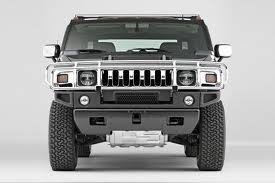

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


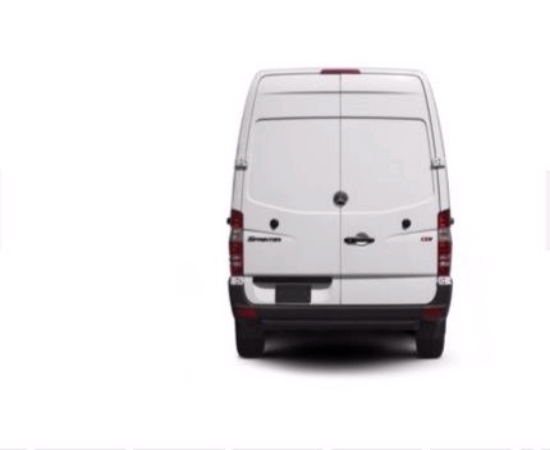

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


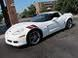

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


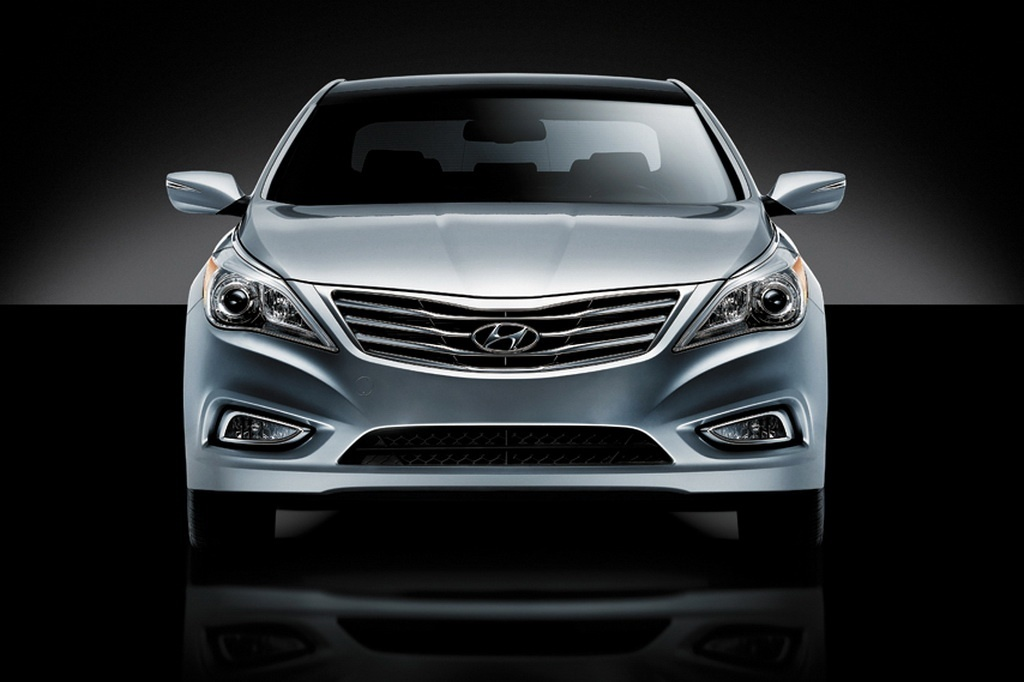

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


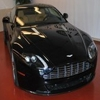

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


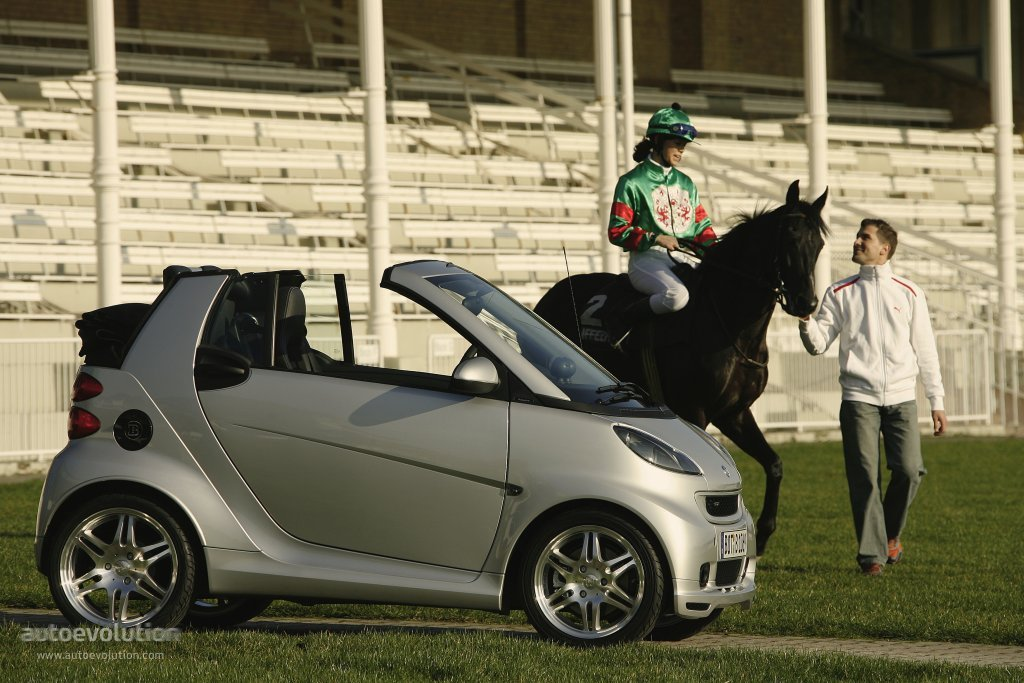

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


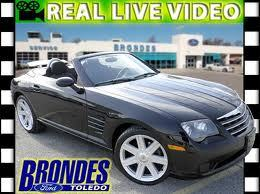

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


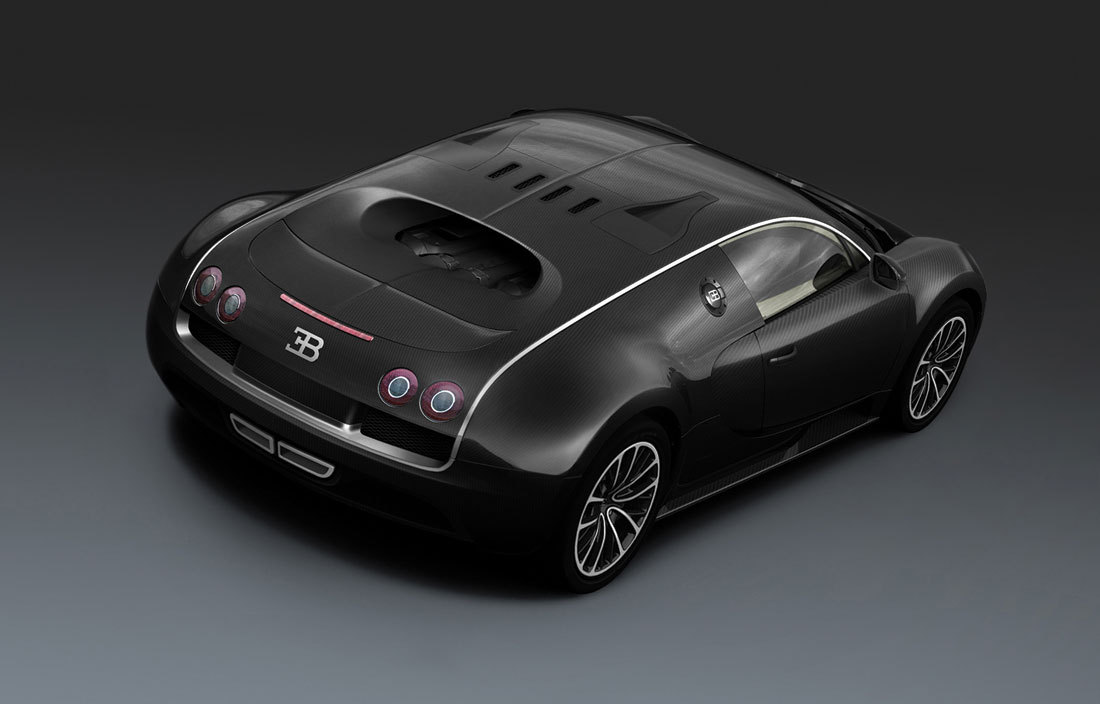

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


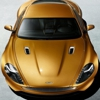

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


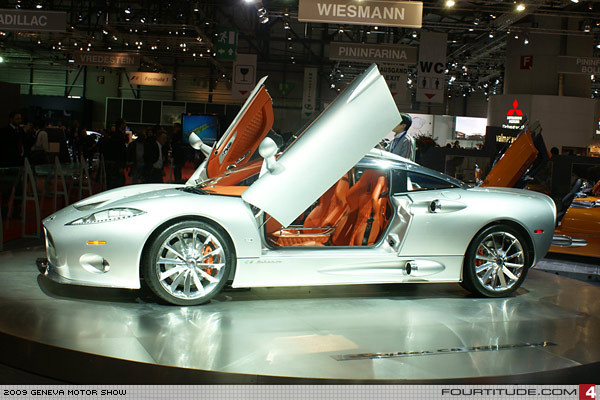

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


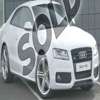

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


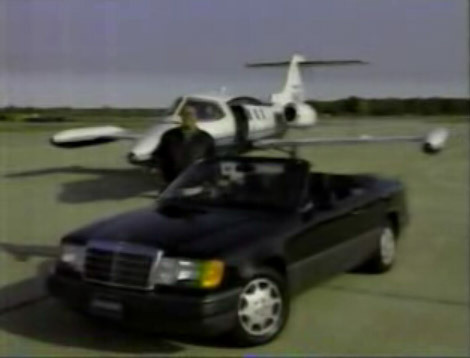

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


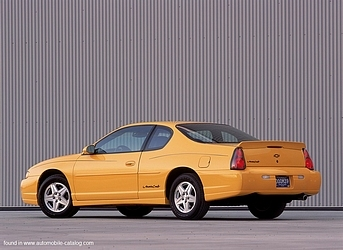

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


FALSE POSITIVE
oc_svm_preds: 1 | actual: 0


FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


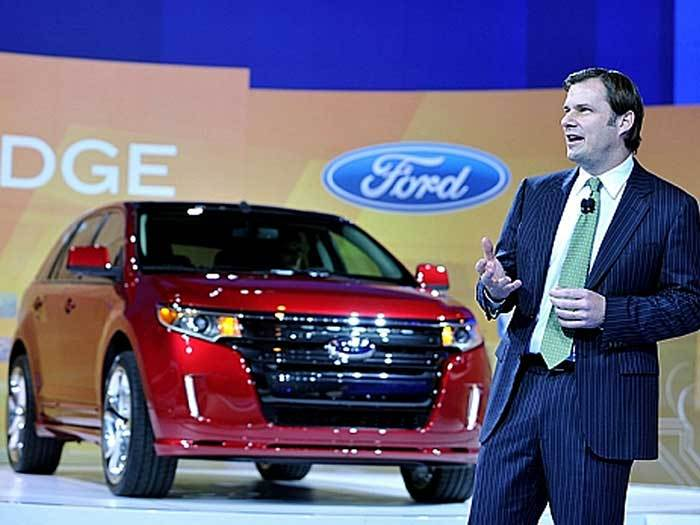

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


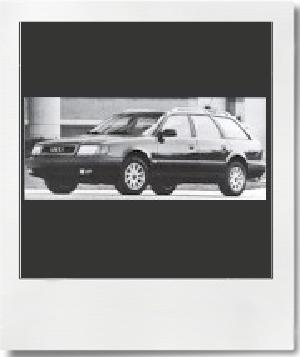

In [ ]:
for index, row in svm_if_results[svm_if_results['oc_svm_preds']!=svm_if_results['is_car']].head(25).iterrows():
    if row['oc_svm_preds']==1:
        print('FALSE POSITIVE')
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_car']))
        display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_car']))
        display(Image(row['path']))

In [ ]:
print('False Positive Actual Image Types for IF: ')
print(svm_if_results[svm_if_results['if_preds']>svm_if_results['is_car']]['image_type'].value_counts())

False Positive Actual Image Types for IF: 
motorbike    18
airplane      1
Name: image_type, dtype: int64


### False Negatives

FALSE NEGATIVE
if_preds: 0 | actual: 1


FALSE NEGATIVE
if_preds: 0 | actual: 1


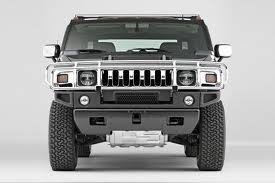

FALSE POSITIVE
if_preds: 1 | actual: 0


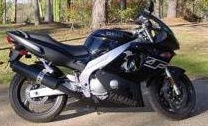

FALSE NEGATIVE
if_preds: 0 | actual: 1


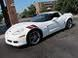

FALSE NEGATIVE
if_preds: 0 | actual: 1


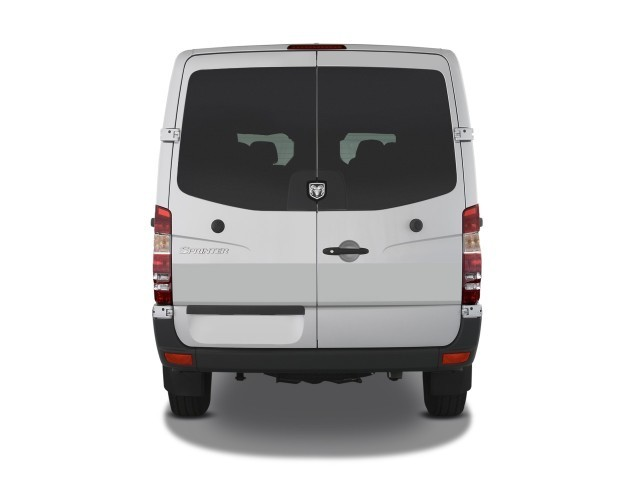

FALSE NEGATIVE
if_preds: 0 | actual: 1


FALSE NEGATIVE
if_preds: 0 | actual: 1


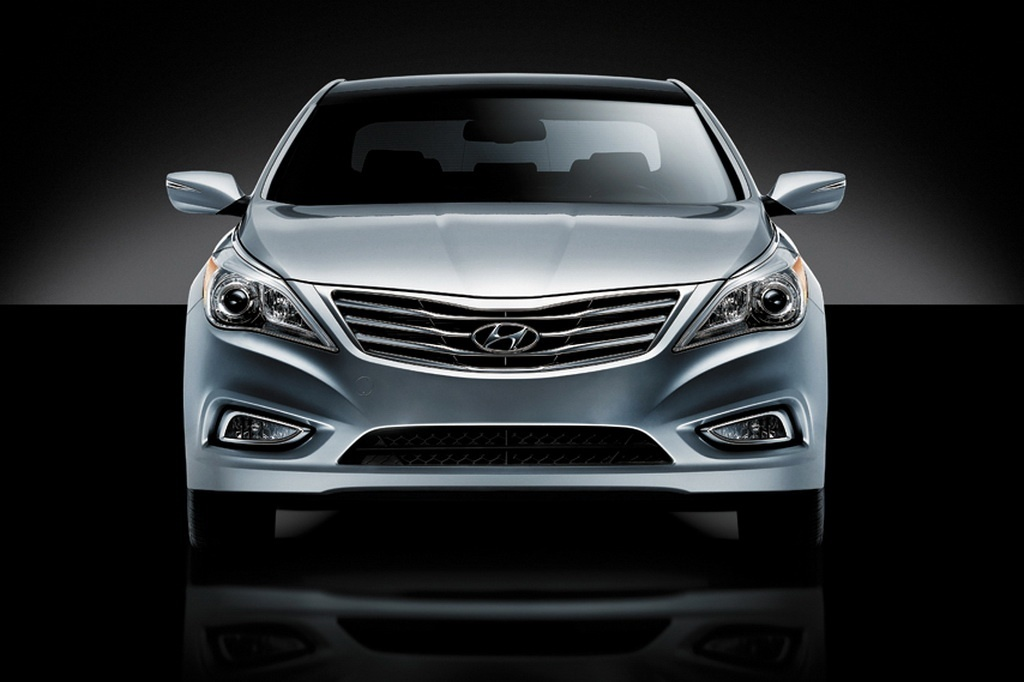

FALSE NEGATIVE
if_preds: 0 | actual: 1


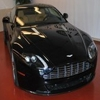

FALSE NEGATIVE
if_preds: 0 | actual: 1


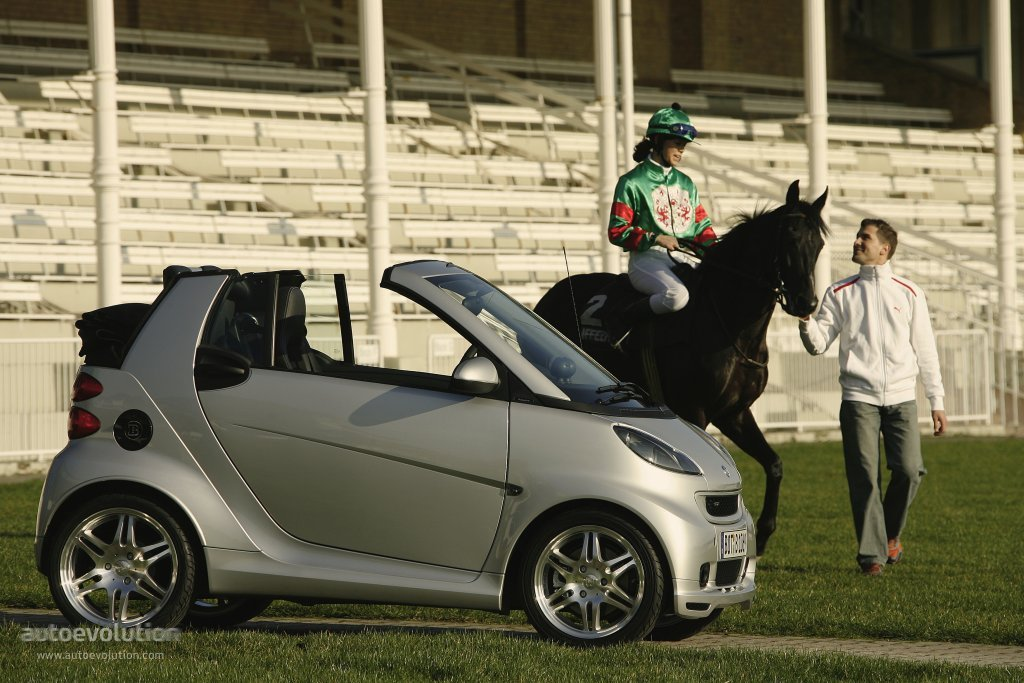

FALSE NEGATIVE
if_preds: 0 | actual: 1


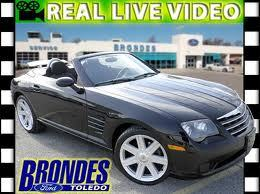

FALSE NEGATIVE
if_preds: 0 | actual: 1


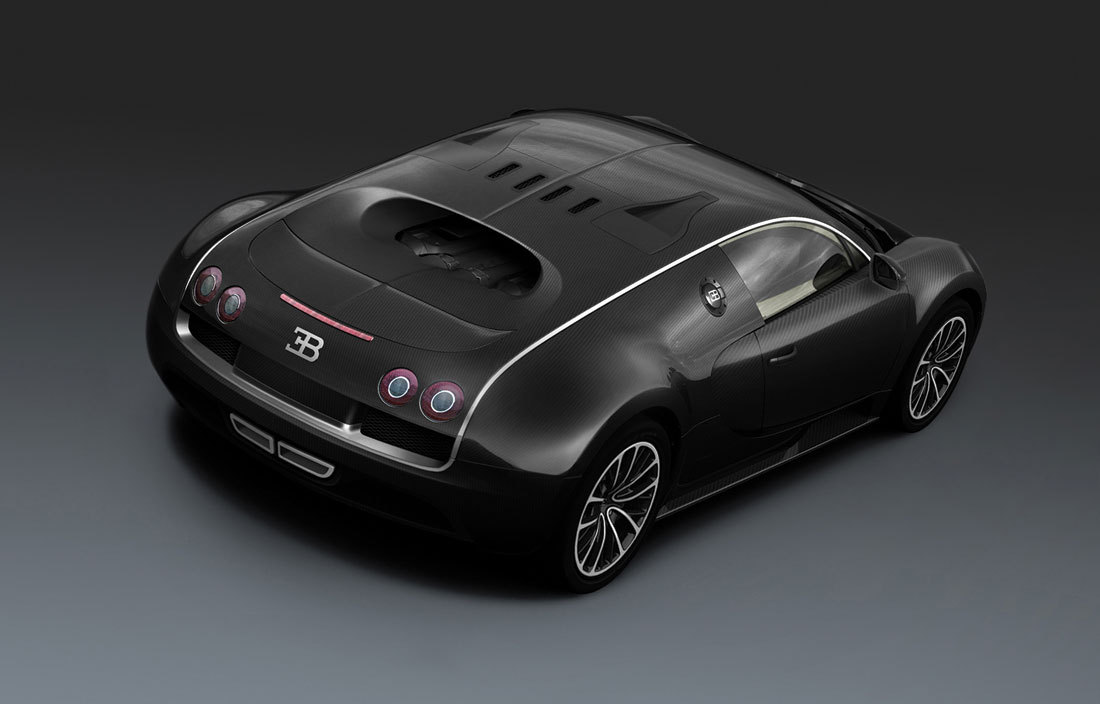

FALSE NEGATIVE
if_preds: 0 | actual: 1


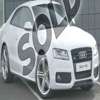

FALSE NEGATIVE
if_preds: 0 | actual: 1


FALSE NEGATIVE
if_preds: 0 | actual: 1


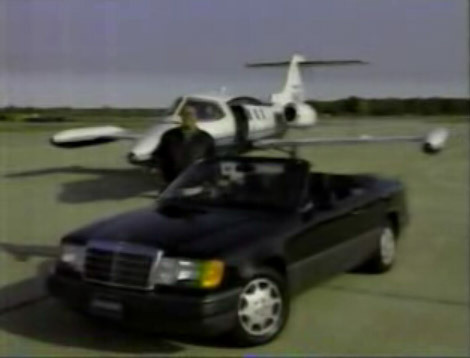

FALSE NEGATIVE
if_preds: 0 | actual: 1


FALSE NEGATIVE
if_preds: 0 | actual: 1


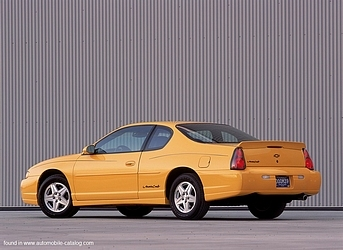

FALSE NEGATIVE
if_preds: 0 | actual: 1


FALSE POSITIVE
if_preds: 1 | actual: 0


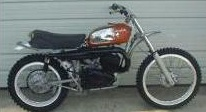

FALSE NEGATIVE
if_preds: 0 | actual: 1


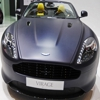

FALSE NEGATIVE
if_preds: 0 | actual: 1


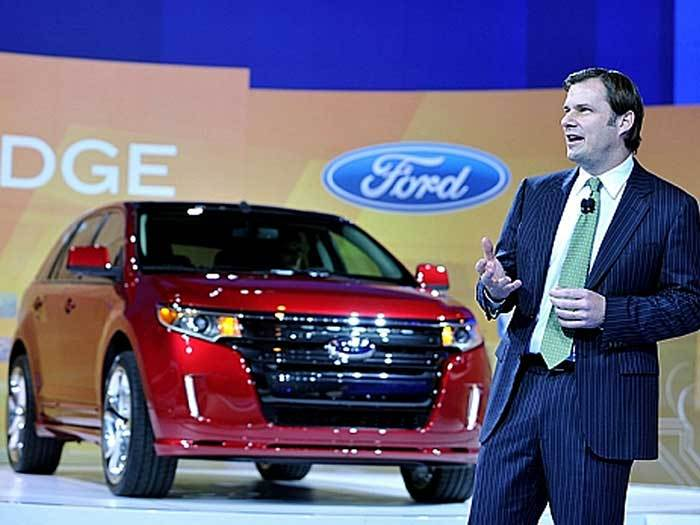

FALSE NEGATIVE
if_preds: 0 | actual: 1


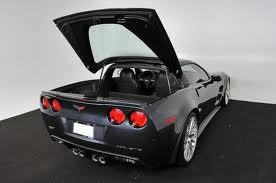

FALSE NEGATIVE
if_preds: 0 | actual: 1


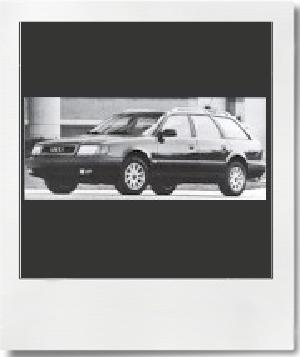

FALSE NEGATIVE
if_preds: 0 | actual: 1


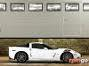

FALSE NEGATIVE
if_preds: 0 | actual: 1


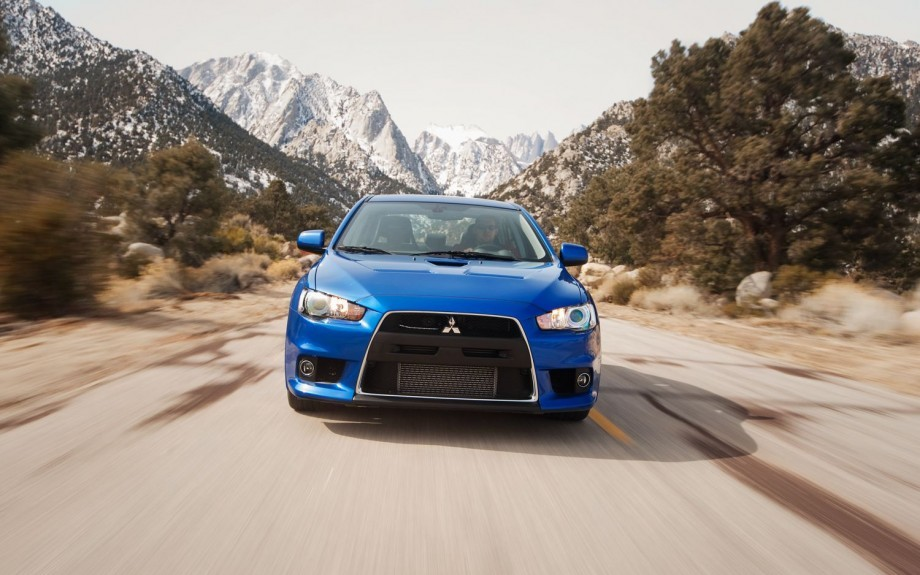

FALSE NEGATIVE
if_preds: 0 | actual: 1


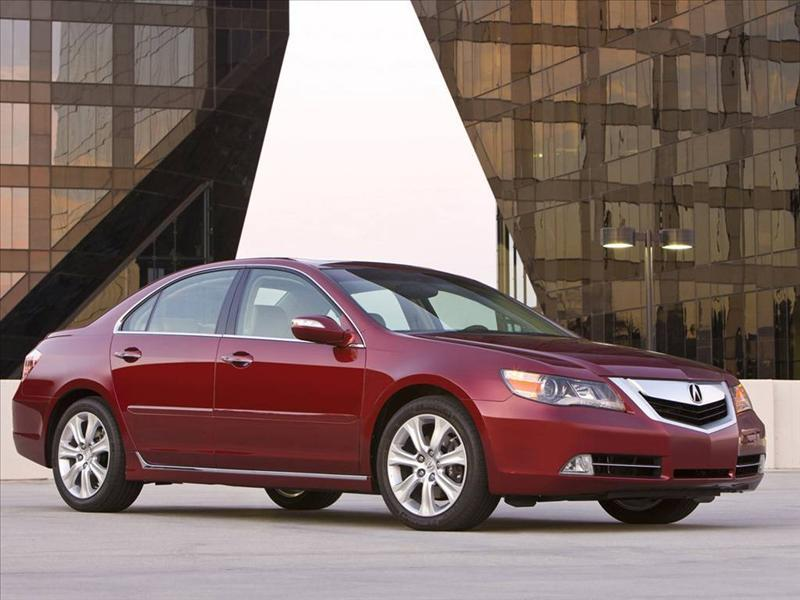

In [ ]:
for index, row in svm_if_results[svm_if_results['if_preds']!=svm_if_results['is_car']].head(25).iterrows():
    if row['if_preds']==1:
        print('FALSE POSITIVE')
        print('if_preds: ' + str(row['if_preds']) + ' | actual: '+ str(row['is_car']))
        display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('if_preds: ' + str(row['if_preds']) + ' | actual: '+ str(row['is_car']))
        display(Image(row['path']))

In [ ]:
print('False Positive Actual Image Types for GMM: ')
print(gmm_results[gmm_results['gmm_preds']>gmm_results['is_car']]['image_type'].value_counts())

False Positive Actual Image Types for GMM: 
motorbike    73
airplane      3
Name: image_type, dtype: int64


FALSE NEGATIVE
gmm_preds: 0 | actual: 1


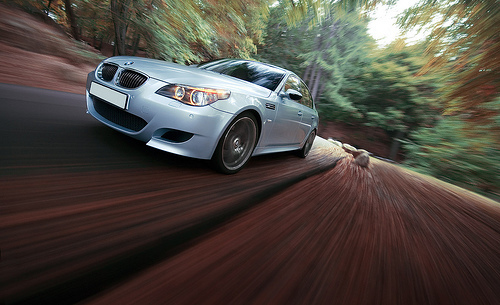

FALSE POSITIVE
gmm_preds: 1 | actual: 0


FALSE POSITIVE
gmm_preds: 1 | actual: 0


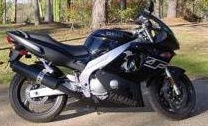

FALSE POSITIVE
gmm_preds: 1 | actual: 0


FALSE NEGATIVE
gmm_preds: 0 | actual: 1


FALSE NEGATIVE
gmm_preds: 0 | actual: 1


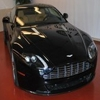

FALSE POSITIVE
gmm_preds: 1 | actual: 0


FALSE POSITIVE
gmm_preds: 1 | actual: 0


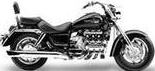

FALSE POSITIVE
gmm_preds: 1 | actual: 0


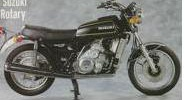

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


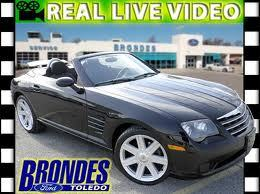

FALSE POSITIVE
gmm_preds: 1 | actual: 0


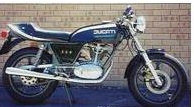

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


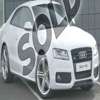

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


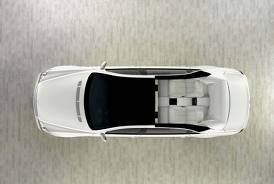

FALSE POSITIVE
gmm_preds: 1 | actual: 0


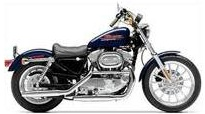

FALSE POSITIVE
gmm_preds: 1 | actual: 0


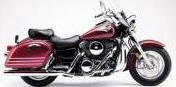

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


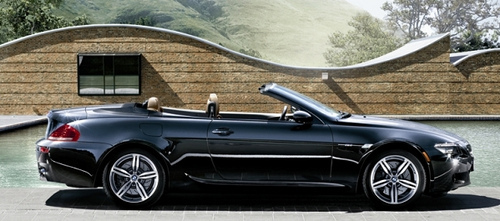

FALSE POSITIVE
gmm_preds: 1 | actual: 0


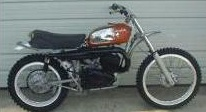

FALSE POSITIVE
gmm_preds: 1 | actual: 0


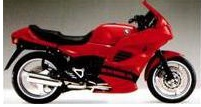

FALSE POSITIVE
gmm_preds: 1 | actual: 0


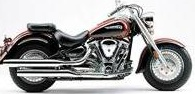

FALSE POSITIVE
gmm_preds: 1 | actual: 0


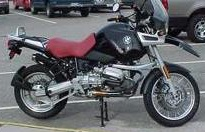

FALSE POSITIVE
gmm_preds: 1 | actual: 0


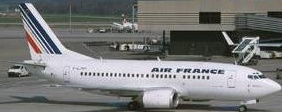

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


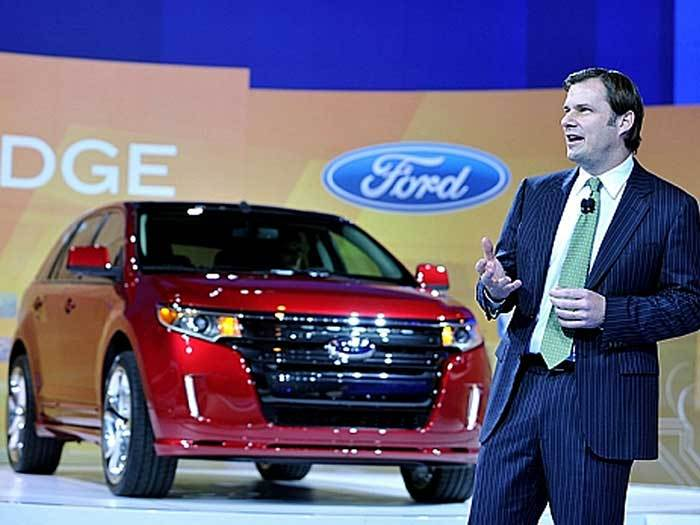

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


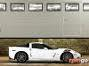

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


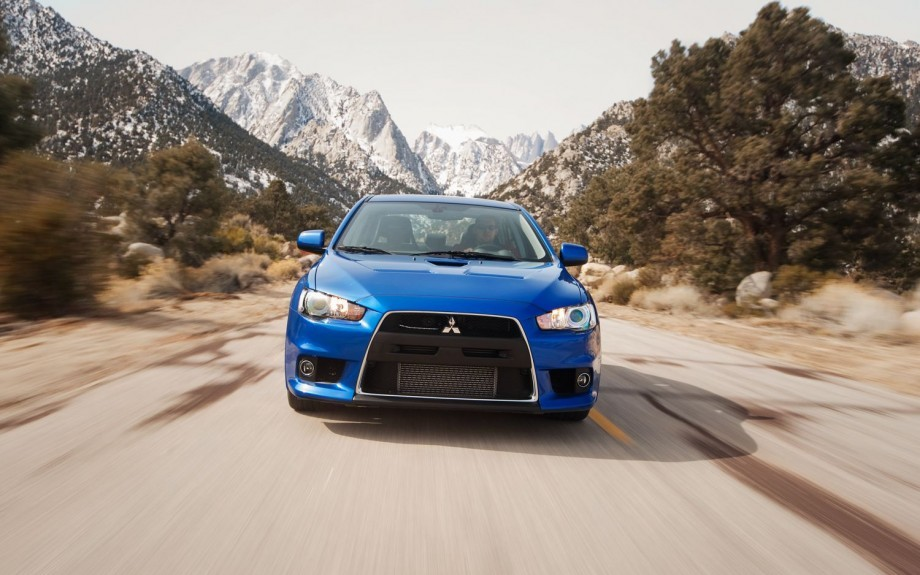

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


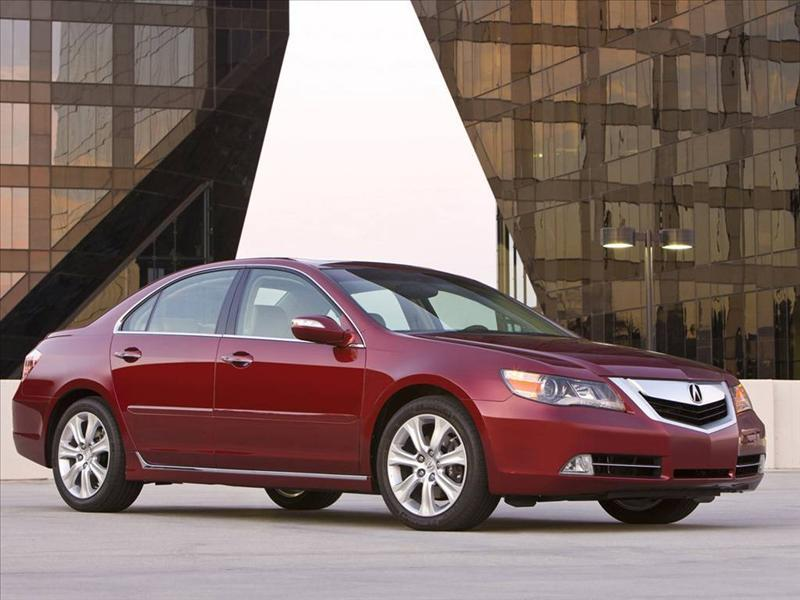

In [ ]:
for index, row in gmm_results[gmm_results['gmm_preds']!=gmm_results['is_car']].head(25).iterrows():
    if row['gmm_preds']==1:
        print('FALSE POSITIVE')
        print('gmm_preds: ' + str(row['gmm_preds']) + ' | actual: '+ str(row['is_car']))
        display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('gmm_preds: ' + str(row['gmm_preds']) + ' | actual: '+ str(row['is_car']))
        display(Image(row['path']))

## Closing Remarks

I hope this notebook was helpful for those interested in learning a bit more about One Class Image Classification and its application toward solving real world problems. I definitely encourage the community to contribute toward handling this tricky problem with other methods that may promise even better results. Thanks to Aniket who wrote the original article on Hackernoon.